In [179]:
include("../code/julia/ha-trade.jl")
using MINPACK
using Plots

This notebook explores my approach to scaling things so one can have country heterogeneity in income.

### Step 1: One country

In the next cells below, I just explore stuff from the perspective of one country in (more or less) autarky. 

In [2]:
TFP_var = 8.0 # Make TFP high here

TFP = [TFP_var; 1.0]
wage = [TFP_var; 1.0]

d_ij = 10.5
d = [1.0 d_ij; d_ij 1.0]

Ncntry = size(d)[1]

γ = 1.5
σϵ = 0.25

hh_prm = household_params(Ncntry = 2, Na = 100, 
γ = γ, ϕ = 0.5, amax = 8.0, σϵ = σϵ, β = 0.92, ρ = 0.90)

agrid = make_agrid(hh_prm, TFP[1])

foo = household_params(hh_prm, agrid = agrid, TFP = TFP[1], σϵ = σϵ*(TFP[1]^(1.0 - γ)));

#the way this grid is setup seems to work

In [3]:
# This then solves the household problem given these wages and interest rate

p = (wage[1:end] ./ TFP).*d[1,:]
R = 1.00

τ = 0.0

@time hh = solve_household_problem(R, wage[1], p, τ, foo)

@time dist = make_stationary_distribution(hh, foo)

 29.016512 seconds (69.40 M allocations: 3.547 GiB, 3.64% gc time, 99.66% compilation time)
  1.365620 seconds (5.33 M allocations: 281.728 MiB, 4.49% gc time, 98.97% compilation time)


distribution{Float64}([0.4072531249999999 0.0 … 0.0 0.0; 0.40725312499999994 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.1227200520446452 0.0; 0.0 0.0 … 0.31952899324102635 0.08765929174455035], [0.01870801062789825; 0.009775798238696723; … ; 4.2629607929220415e-91; 2.827495137748886e-106;;], [(1, 1); (2, 1); … ; (99, 10); (100, 10);;])

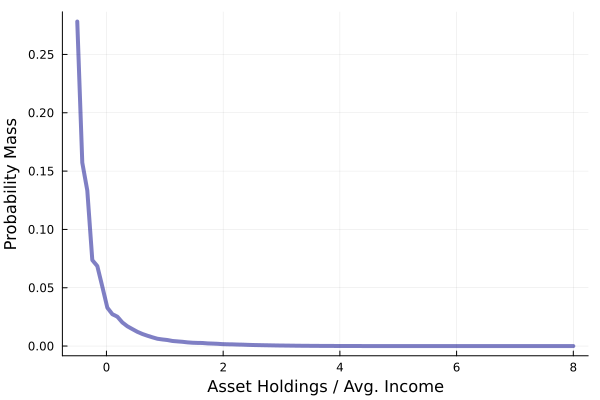

In [4]:
wz, ef = get_laborincome(wage[1], dist.state_index, foo)

avg_income = sum(wz.*dist.λ)

adist = get_distribution(dist.state_index, dist.λ);

plot(foo.agrid ./ avg_income, adist, alpha = 0.5, lw = 4,
    color = "dark blue", ylabel = "Probability Mass", 
    xlabel = "Asset Holdings / Avg. Income", label = false)

Then this distribution should look invariant to the level of TFP. Play around with the TFP_var above to verify this.

---

### Step 2 Two Country Model

Now I do a two country model and vary the level of things again. This again should result in (i) patterns of trade not depending upon the level and (ii) an asset distribution that is the same when scaled by income. 

In [43]:
# This picks the level of the economy...
TFP_level = 1.0

1.0

In [44]:
TFP = TFP_level.*[1.0; 1.0]

τ = [0.0; 0.0]

L = [1.0; 1.0]

d_ij = 1.745

d = [1.0 d_ij; d_ij 1.0]

# this sets up the country specific paramters
cntry_prm = country_params(Ncntry = Ncntry, L = L, d = d, TFP = TFP);

In [45]:
f(x) = world_equillibrium_FG(exp.(x), hh_prm, cntry_prm)
# this world... function is used to construct zero conditions for
# the finacial globalization case

function f!(fvec, x)

    fvec .= f(x)

end


xguess = [TFP_level; 1.02]

n = length(xguess)
diag_adjust = n - 1

sol = fsolve(f!, log.(xguess), show_trace = true, method = :hybr;
      ml=diag_adjust, mu=diag_adjust,
      diag=ones(n),
      mode= 1,
      tol=1e-10,
       )

# This solver works very well in general. Spencer Lyon converted old-school minpack
# routines in C into julia

print(sol)

wage = [exp.(sol.x[1]); cntry_prm.TFP[end]]
R = exp.(sol.x[2])

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     1.560862e-01     0.000000e+00         0.130000
     2     1.456059e-02     2.654986e-05         0.365000
     3     1.638137e-03     4.506004e-07         0.118000
     4     1.812301e-05     7.164351e-09         0.130000
     5     1.674584e-08     9.008308e-13         0.111000
     6     6.698718e-11     8.321748e-19         0.121000
     7     3.676642e-13     1.185695e-23         0.097000
     8     1.179612e-15     3.365318e-28         0.143000
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [0.0, 0.01980262729617973]
 * Zero: [-2.039586404137559e-9, 0.014094023815588037]
 * Inf-norm of residuals: 0.000000
 * Convergence: true
 * Message: algorithm estimates that the relative error between x and the solution is at most tol
 * Total time: 1.215000 seconds
 * Function Calls: 8
 * Jacobian Calls (df/dx): 1

1.0141938128276817

In [46]:
wage

2-element Vector{Float64}:
 0.9999999979604136
 1.0

In [47]:
R

1.0141938128276817

In [48]:
Rsol = [R; R]

Y, tradeflows, A_demand, Gbudget, tradeshare, hh, dist = world_equillibrium(Rsol, wage, τ, hh_prm, cntry_prm, tol_vfi = 1e-10);

In [49]:
tradeshare

# The pattern of trade should not be varying with level either

2×2 Matrix{Float64}:
 0.900484   0.0995163
 0.0995163  0.900484

In [50]:
hh[1].πprob[:,:,2]

# This should not be changing as we vary the level of stuff

100×10 Matrix{Float64}:
 0.00747609  0.0192432  0.0202433  0.0386541  …  0.103814  0.123432  0.138619
 0.0139284   0.0212163  0.0281047  0.0428235     0.105277  0.127093  0.139288
 0.0194756   0.0264393  0.0357197  0.0456883     0.106613  0.129608  0.139941
 0.0218411   0.0282292  0.0387705  0.0478642     0.107806  0.131053  0.140583
 0.0265513   0.0302667  0.042976   0.0506709     0.108911  0.132266  0.141216
 0.0285041   0.0333028  0.0457674  0.0530594  …  0.109967  0.133278  0.141837
 0.030625    0.0352261  0.0480061  0.0548275     0.111015  0.134253  0.142449
 0.0333905   0.0371223  0.0507749  0.0564595     0.112049  0.135159  0.143062
 0.0354688   0.039016   0.0531147  0.0582905     0.112984  0.136008  0.143643
 0.037335    0.0409391  0.0548801  0.0601975     0.113907  0.136789  0.144216
 0.0392264   0.0426161  0.0565561  0.061869   …  0.114807  0.137517  0.14478
 0.0411777   0.0442844  0.058384   0.0633612     0.115682  0.138219  0.145336
 0.0428169   0.0459213  0.0602438  0.0647

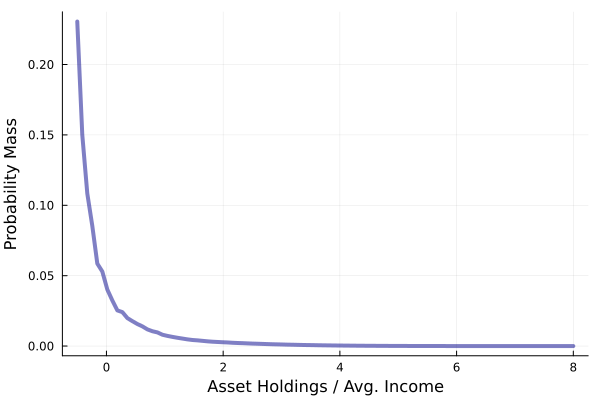

In [51]:
cntry = 1

agrid = make_agrid(hh_prm, TFP[cntry])

foo = household_params(hh_prm, agrid = agrid, 
                TFP = TFP[cntry], L = L[cntry], σϵ = σϵ*(TFP[cntry]^(1.0 - γ)), ψ = hh_prm.ψ)

wz, ef = get_laborincome(wage[cntry], dist[cntry].state_index, foo)

avg_income = sum(wz.*dist[cntry].λ)

adist = get_distribution(dist[cntry].state_index, dist[cntry].λ);

plot(foo.agrid ./ avg_income, adist, alpha = 0.5, lw = 4,
    color = "dark blue", ylabel = "Probability Mass", 
    xlabel = "Asset Holdings / Avg. Income", label = false)

And then this set of code makes sure that elasticities are not varying with the level

In [53]:
p = make_p(wage, TFP, d[cntry, :], cntry_prm.tariff[cntry, :] )

θ = make_θ(cntry, R, wage[cntry], p, τ[cntry], foo; points = 3, order = 1)
# makes the micro elasticities for country, cntry, 

ω = make_ω(hh[cntry], dist[cntry], L[cntry], p, foo)
# makes the expenditure weights

agθ = aggregate_θ(θ, ω, cntry, foo)
# construct the aggregate elasticity. The interesting element here is 
# agθ[cntry]

2-element Vector{Float64}:
  1.0
 -4.122612728494185

---

### Step 3 Quality differences

Now we want to make sure that quality is scaled correctly as well.

In [196]:
γ = 1.50 # curvatuve on CRRA utility function
σϵ = 0.25 # logit dispersion parameter
Ncntry = 2 # number of countries

# this setups up parameters on the household side
hh_prm = household_params(Ncntry = Ncntry, Na = 100, β = 0.92, γ = γ, ϕ = 0.5, amax = 8.0, σϵ = σϵ, ψslope = 0.2);

#ψslope controls how residual demand varies with income state....

In [197]:
TFP_level = 10.0

# here are some simpe country parametrers
TFP = TFP_level.*[1.0; 1.0]

τ = [0.0; 0.0]

L = [1.0; 1.0]

d_ij = 1.745

d = [1.0 d_ij; d_ij 1.0]

# this sets up the country specific paramters
cntry_prm = country_params(Ncntry = Ncntry, L = L, d = d, TFP = TFP);

In [198]:
f(x) = world_equillibrium_FG(exp.(x), hh_prm, cntry_prm)
# this world... function is used to construct zero conditions for
# the finacial globalization case

function f!(fvec, x)

    fvec .= f(x)

end


xguess = [TFP_level; 1.02]

n = length(xguess)
diag_adjust = n - 1

sol = fsolve(f!, log.(xguess), show_trace = true, method = :hybr;
      ml=diag_adjust, mu=diag_adjust,
      diag=ones(n),
      mode= 1,
      tol=1e-10,
       )

# This solver works very well in general. Spencer Lyon converted old-school minpack
# routines in C into julia

print(sol)

wage = [exp.(sol.x[1]); cntry_prm.TFP[end]]
R = exp.(sol.x[2])

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     1.889015e+00     0.000000e+00         0.131000
     2     2.011414e-01     3.677513e-05         0.335000
     3     2.740436e-02     9.361774e-07         0.100000
     4     4.372331e-04     2.305497e-08         0.168000
     5     2.964094e-06     5.606878e-12         0.139000
     6     7.749646e-09     2.721273e-16         0.103000
     7     1.284417e-11     1.802735e-21         0.101000
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [2.302585092994046, 0.01980262729617973]
 * Zero: [2.3025850906772787, 0.012990290406706321]
 * Inf-norm of residuals: 0.000000
 * Convergence: true
 * Message: algorithm estimates that the relative error between x and the solution is at most tol
 * Total time: 1.077000 seconds
 * Function Calls: 7
 * Jacobian Calls (df/dx): 1

1.0130750307655298

In [199]:
wage

2-element Vector{Float64}:
  9.99999997683233
 10.0

In [200]:
R

1.0130750307655298

In [201]:
Rsol = [R; R]

Y, tradeflows, A_demand, Gbudget, tradeshare, hh, dist = world_equillibrium(Rsol, wage, τ, hh_prm, cntry_prm, tol_vfi = 1e-10);

In [202]:
tradeshare

2×2 Matrix{Float64}:
 0.919293   0.0807066
 0.0807066  0.919293

In [203]:
hh[1].πprob[:,:,2]
# guys in country one, a X z, probability of buying from 2

100×10 Matrix{Float64}:
 0.0153874  0.0389713  0.0289009  …  0.0749608  0.0640053  0.0728029
 0.0284216  0.042925   0.0399521     0.0760607  0.0661423  0.0731829
 0.0394186  0.0529172  0.05056       0.0770306  0.0676554  0.0735568
 0.0441193  0.056503   0.0547915     0.0779161  0.0685637  0.0739241
 0.0531311  0.0605085  0.0605846     0.0787469  0.0692215  0.0742847
 0.0570407  0.0661851  0.0644315  …  0.0795477  0.069815   0.0746472
 0.0611752  0.0699163  0.0675571     0.0803421  0.0703682  0.0749934
 0.0663712  0.073557   0.0713012     0.0810946  0.0708869  0.075328
 0.0703746  0.0771641  0.0744958     0.0818011  0.0713386  0.075658
 0.0739593  0.0807869  0.0769521     0.0824948  0.0717678  0.0759826
 0.0775502  0.0839139  0.0792597  …  0.0831723  0.0721787  0.0763022
 0.081191   0.0870507  0.0817287     0.083828   0.0725769  0.0766182
 0.0843079  0.0901137  0.0842488     0.0844674  0.0729753  0.0769312
 ⋮                                ⋱                        
 0.206205   0.208025 

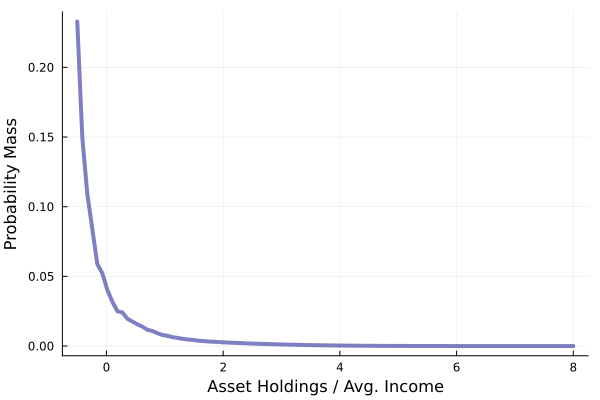

In [204]:
cntry = 1

agrid = make_agrid(hh_prm, TFP[cntry])

foo = household_params(hh_prm, agrid = agrid, 
                TFP = TFP[cntry], L = L[cntry], σϵ = σϵ*(TFP[cntry]^(1.0 - γ)), ψ = hh_prm.ψ)

wz, ef = get_laborincome(wage[cntry], dist[cntry].state_index, foo)

avg_income = sum(wz.*dist[cntry].λ)

adist = get_distribution(dist[cntry].state_index, dist[cntry].λ);

plot(foo.agrid ./ avg_income, adist, alpha = 0.5, lw = 4,
    color = "dark blue", ylabel = "Probability Mass", 
    xlabel = "Asset Holdings / Avg. Income", label = false)

In [205]:
p = make_p(wage, TFP, d[cntry, :], cntry_prm.tariff[cntry, :] )

θ = make_θ(cntry, R, wage[cntry], p, τ[cntry], foo; points = 3, order = 1)
# makes the micro elasticities for country, cntry, 

ω = make_ω(hh[cntry], dist[cntry], L[cntry], p, foo)
# makes the expenditure weights

agθ = aggregate_θ(θ, ω, cntry, foo)
# construct the aggregate elasticity. The interesting element here is 
# agθ[cntry]

2-element Vector{Float64}:
  1.0
 -4.3985154500003905